# 8 循环神经网络

**循环神经网络（recurrent neural network，RNN）** 是一种专门用于处理序列数据（见 7.5）的神经网络架构。 RNN 的核心思想是：当前时刻的输出不仅取决于当前时刻的输入，还取决于之前时刻的状态（记忆）。



## 8.1 序列模型

处理序列数据需要统计工具和新的深度神经网络架构。

对于序列数据 $x_t$ ，其需基于前面数据进行预测，即：

$$x_t \sim P(x_t|x_{t-1},...,x_1)$$

输入数据的数量将会随着遇到的数据量的增加而增加，因此需要一个近似方法来使这个计算变得容易处理：

- **自回归模型（autoregressive models）** ：

在现实情况下相当长的序列 $x_{t-1},...,x_1$ 可能是不必要的，因此只需要满足某个长度为 $\tau$ 的时间跨度，即使用观测序列 $x_{t-1},...,x_{t-\tau}$ 。

- **隐变量自回归模型（latent autoregressive models）** ：

保留一些对过去观测的总结 $h_t$ ，并且同时更新预测 $\hat{x}_t$ 和总结 $h_t$ 。这就产生了基于 $\hat{x}_t = P(x_t | h_t)$ 估计 $x_t$ ，以及公式 $h_t = g(h_{t-1}, x_{t-1})$ 更新的模型。



#### 马尔可夫模型

在自回归模型的近似法中，我们使用 $x_{t-1},...,x_{t-\tau}$ 而不是 $x_{t-1},...,x_1$ 来估计 $x_t$ ，只要这种是近似精确的，我们就说序列满足马尔可夫条件（Markov condition）。

特别是，如果 $\tau = 1$ ，得到一个一阶马尔可夫模型（first-order Markov model）， $P(x)$ 由下式给出：

$$P(x_1,...x_T) = \prod_{t=1}^{T} P(x_t|x_{t-1}) \text{  当}P(x_1|x_0) = P(x_1)$$

以上式子的成立基于 **静止性原则** 和 **因果关系** 。


#### 预测

**单步预测（one-step-ahead prediction）** ：

每次只预测下一个时间点的值，然后将这个预测值作为已知输入用于预测再下一个时间点。

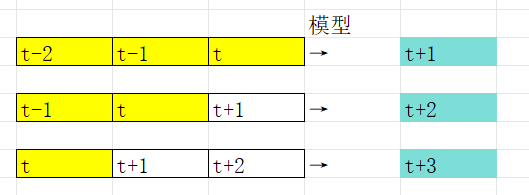

**k步预测（k-Step Forecast）** ：

一次性直接预测未来k个时间点的值，所有预测（在这一次性内）都基于相同的历史真实数据。

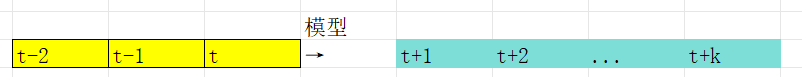

随着对预测时间k值的增加，会造成误差的快速累积和预测质量的急速下降。

## 8.2 文本预处理

文本的常见预处理步骤通常包括：

1. 将文本作为字符串加载到内存中
2. 将字符串拆分为词元（如单词和字符）
3. 建立一个词表，将拆分的词元映射到数字索引
4. 将文本转换为数字索引序列，方便模型操作

#### 读取数据集

#### 词元化

将连续的字符串分割为更小的单元，这些单元称为 **token(s)** 。这些单元可以是单词、子词或字符等。

例如：

'I love deep learning.'

- 按单词拆分：["I", "love", "deep", "learning", "."]
- 按字符拆分：["I", " ", "l", "o", "v", "e", ...]

将非结构化文本转化为结构化单元。

#### 词表

词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。

**词表（vocabulary）** 是一种字典，用来将字符串类型的词元映射到从 0 开始的数字索引中。

构建词表的流程如下：

1. **收集所有词元（Token）**
2. **统计词频** ：

    在收集词元的同时，通常统计每个词元出现的频率。这有助于过滤掉一些低频词，这些词可能是拼写错误或罕见词，从而控制词表大小。

3. **添加特殊标记（Special Tokens）** ：

    无论哪种词表，我们都需要添加一些特殊标记，用于处理文本中的特殊情况。常见的特殊标记包括：
    - [PAD]：填充标记，用于将不同长度的序列补齐到相同长度。
    - [UNK]：未知词标记，用于表示不在词表中的词。语料库中不存在或已删除的任何词元都将映射到其。
    - [CLS]：分类标记，通常用于序列分类任务，位于整个序列的开头。
    - [SEP]：分隔标记，用于分隔两个句子（如问答任务中的问题和答案）或标记序列结束。
    - [MASK]：掩码标记，用于预训练任务（如BERT）中遮盖部分词元。

    *注：这些所谓的标记其实也就可以看做是一种特殊的词元，这些词元也需要对应于特定的数字索引，例如在一般情况下，\<unk\> 以及 \<pad\> 对应于 0 和 1。*

4. **索引分配（Index Assignment）** ：

    为词表中的每个词元分配一个唯一的整数索引。通常，特殊标记会放在最前面（索引0开始），然后按词频降序分配索引。

5. **序列化存储** ：

    将词表保存为文件，通常是一个每行一个词元的文本文件，或者一个包含词元到索引映射的JSON文件。

构建完词表后就可以将文本信息转换为对应的数字序列。

## 8.3 数据集处理

假设长度为T的文本序列中的词元依次为$x_1, x_2, ..., x_T$。于是，$x_t(1 \leq t \leq T)$ 可以被认为是文本序列在时间步 $t$ 处的观测或标签。 **语言模型（language model）** 的目标是估计序列的联合概率：

$$P(x_1,x_2,...,x_T)$$

由于序列数据本质上是连续的，当序列变得太长而不能被模型一次性全部处理时，需要拆分这样的序列。有两种策略进行划分：



#### 随机采样


先随机选一个起始点，从这个位置开始切分文本，记录每个子序列的起始位置。然后把所有起始位置随机打乱，这样相邻批次的子序列在原文中就不相邻。



#### 顺序分区

*注：原教材中的小批量即是最终采得的子序列*


## 8.4 循环神经网络

为了使得在 $x_t$ 上的预测能够利用以前的所有数据，（ *参照 8.1 中提到的隐变量自回归模型* ）需要将 8.3 中的n元语法模型改编为隐变量模型：

$$P(x_t|x_{t-1},...,x_1) \approx P(x_t | h_{t-1})$$

其中 $h_{t-1}$ 是 **隐状态（hidden state）** ，也称为 **隐藏变量（hidden variable）** 。



**循环神经网络（recurrent neural networks，RNNs）** 是具有隐状态的神经网络。

与多层感知机不同，循环神经网络引入了前一个时间步的隐藏变量 $\textbf{H}_{t-1}$ ，并引入了一个新的权重参数 $W_{hh} \in \mathbb{R}^{h\times h}$ ，来描述如何在当前时间步中使用前一个时间步的隐藏变量：

$$H_t = \phi(\textbf{X}_t\textbf{W}_{xh} + \textbf{H}_{t-1}\textbf{W}_{hh}+\textbf{b}_h)$$

其中，隐状态中 $\textbf{X}_t\textbf{W}_{xh} + \textbf{H}_{t-1}\textbf{W}_{hh}$ 的计算，相当于 $X_t$ 和 $H_{t-1}$ 的拼接与 $\textbf{W}_{xh}$ 和 $\textbf{W}_{hh}$ 的拼接的矩阵乘法。在循环神经网络中执行这样计算的层称为 **循环层（recurrent layer）** 。

输出层的输出类似于多层感知机的计算：

$$\textbf{O}_{t} = \textbf{H}_t \textbf{W}_{hq} + \textbf{b}_q$$



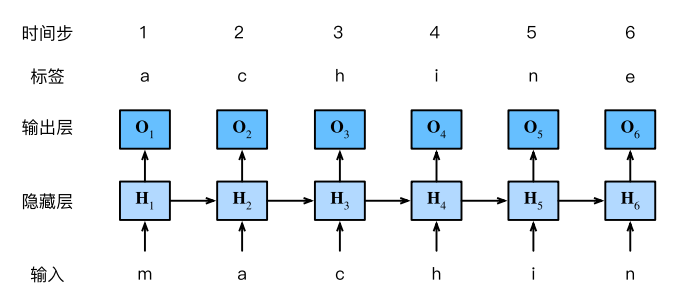

#### 困惑度

**困惑度（Perplexity，PPL）** 是自然语言处理（NLP）中用于评估语言模型性能的重要指标。它衡量模型对一组测试数据（通常是文本）的概率预测的不确定性。困惑度越低，表示模型对数据的预测越准确，不确定性越小。

*注：困惑度的导出应当参考这个学期的选修课程《信息论》。*

$$\exp\left( -\frac{1}{n} \sum_{t=1}^{n} \log P(x_t \mid x_{t-1}, \dots, x_1) \right)$$

困惑度的最好的理解是“下一个词元的实际选择数的调和平均数”：
- 在最好的情况下，模型总是完美地估计标签词元的概率为1。在这种情况下，模型的困惑度为1。
- 在最坏的情况下，模型总是预测标签词元的概率为0。在这种情况下，困惑度是正无穷大。
- 在基线上，该模型的预测是词表的所有可用词元上的均匀分布。在这种情况下，困惑度等于词表中唯一词元的数量。事实上，如果我们在没有任何压缩的情况下存储序列，这将是我们能做的最好的编码方式。因此，这种方式提供了一个重要的上限，而任何实际模型都必须超越这个上限。